In [1]:
# imports
import warnings
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, BackupAndRestore, EarlyStopping
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# general settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# EDA

In [3]:
# load training data
train_dataset = image_dataset_from_directory("data/train_data", 
                                             batch_size=9,
                                             image_size=(224,224))

Found 922 files belonging to 2 classes.


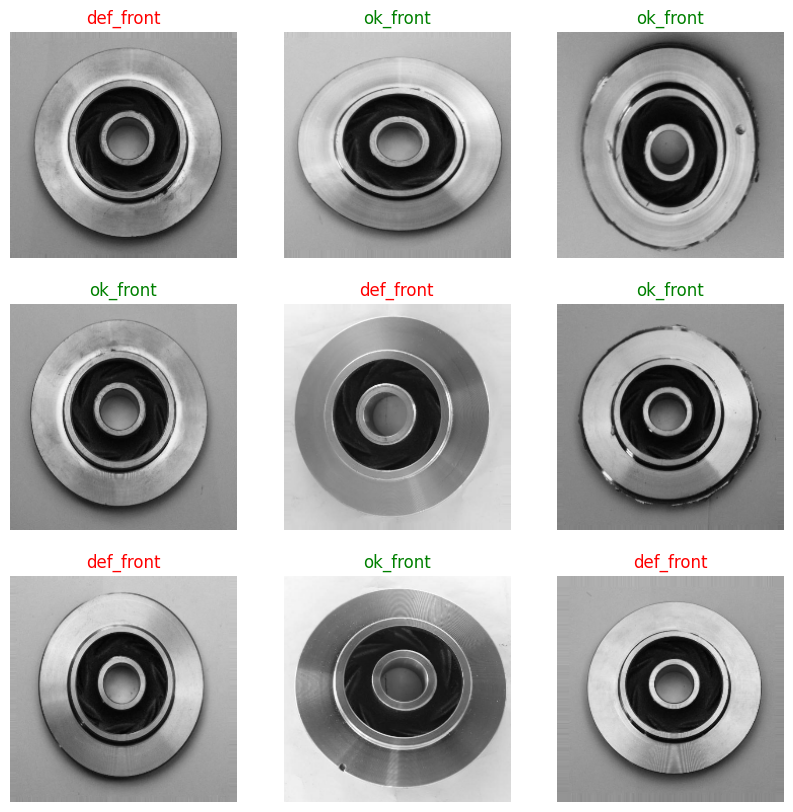

In [4]:
# plot samples
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    axe = plt.subplot(3, 3, i + 1)
    axe.imshow(images[i].numpy().astype("uint8"))
    if class_names[labels[i]] == "ok_front":
      axe.set_title(class_names[labels[i]], color="green")
    else:
      axe.set_title(class_names[labels[i]], color="red")
    plt.axis("off")

# Data Preprocessing

In [5]:
batch_size = 16
# data augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.3,
        rotation_range=180,
        brightness_range=[0.7, 1.0],
        horizontal_flip=True,
        vertical_flip=True)

# augmentation configuration for testing
validation_datagen = ImageDataGenerator(rescale=1./255)

# training data generator
train_generator = train_datagen.flow_from_directory(
        "data/train_data",  
        target_size=(224, 224),
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary")  

# validation data generator
validation_generator = validation_datagen.flow_from_directory(
        "data/test_data",
        target_size=(224, 224),
        batch_size=batch_size,
        shuffle=False,
        class_mode="binary")

Found 922 images belonging to 2 classes.
Found 378 images belonging to 2 classes.


# Modeling

In [6]:
# define the baseline model architecture
inputs = Input(shape=(224, 224, 3))
x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(units=128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(units=1, activation="sigmoid")(x)
baseline_model = Model(inputs=inputs, outputs=outputs)

In [7]:
# compile CNN
baseline_model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=0.0005),
              metrics=["accuracy"])

In [8]:
# define callbacks for the baseline model
base_line_checkpoint = ModelCheckpoint(
    filepath="callbacks/baseline_model_checkpoint.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True)
backup = BackupAndRestore(backup_dir="callbacks/backup")
baseline_model_callbacks=[backup, base_line_checkpoint]

In [9]:
# train the baseline model
baseline_model_history = baseline_model.fit(x=train_generator, 
        steps_per_epoch=922//batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=378//batch_size,
        callbacks=baseline_model_callbacks)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 847ms/step - accuracy: 0.5399 - loss: 0.9028 - val_accuracy: 0.6277 - val_loss: 0.6059
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7500 - loss: 0.2736 - val_accuracy: 0.0000e+00 - val_loss: 0.4865
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 649ms/step - accuracy: 0.6411 - loss: 0.6206 - val_accuracy: 0.6522 - val_loss: 0.6036
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.2740 - val_accuracy: 0.5000 - val_loss: 0.5309
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 628ms/step - accuracy: 0.6918 - loss: 0.6005 - val_accuracy: 0.7364 - val_loss: 0.5594
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.1947 - val_accuracy: 0.7000 - val_loss: 0.3362
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 633ms/step - accuracy: 0.7375 - loss: 0.5571 - val_accuracy: 0.6685 - val_loss: 0.6244
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7500 - loss: 0.2432 - val_a

In [17]:
def plot_history(history, training_metric, validation_metric, figsize=(8,8)):
        # get training and validation metric
        train_metric = history.history[training_metric]
        val_metric = history.history[validation_metric]
        # training and validation loss
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        # plot training and validation accuracy
        plt.figure(figsize=figsize)
        plt.subplot(2, 1, 1)
        plt.plot(train_metric, label=training_metric)
        plt.plot(val_metric, label=validation_metric)
        plt.legend()
        plt.ylabel(training_metric)
        plt.ylim([min(plt.ylim()),1])
        # plot training and validation loss
        plt.subplot(2, 1, 2)
        plt.plot(train_loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.legend()
        plt.ylabel("Cross Entropy")
        plt.ylim([0,1.0])
        plt.xlabel("epoch")
        plt.show()

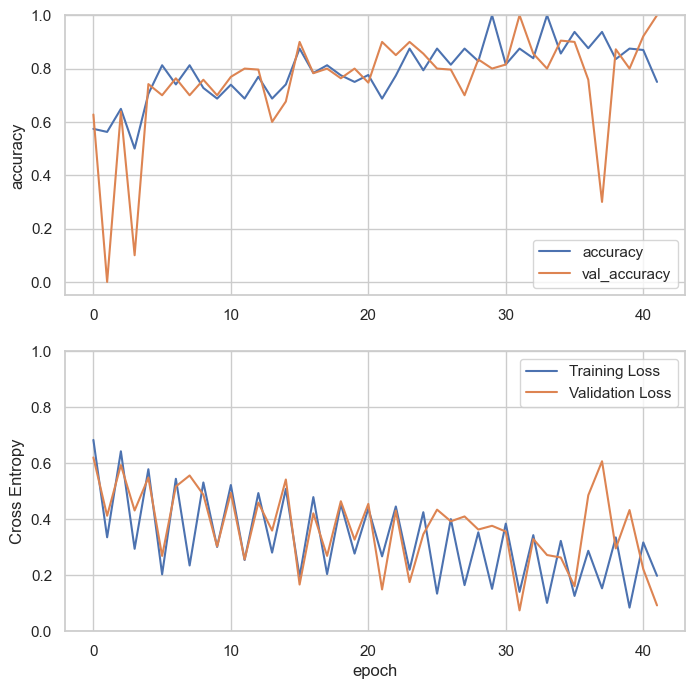

In [18]:
# plot history loss and accuracy over epochs
plot_history(baseline_model_history, training_metric="accuracy", validation_metric="val_accuracy")

In [33]:
# import MobileNetV2 as base model for fine tuning
base_model = MobileNetV2(input_shape=(224,224,3),
                    include_top=False,
                    weights="imagenet")

In [ ]:
# plot the base model summary 
base_model.summary()

In [35]:
# add layers to the base model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x = Flatten()(x)
x = Dense(units=128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(units=1, activation="sigmoid")(x)
fine_tuned_model = Model(inputs=inputs, outputs=outputs)

In [36]:
# Freeze base model layers
for layer in base_model.layers:
  layer.trainable = False

In [37]:
# define the fine tuned model callbacks
fine_tuned_model_checkpoint = ModelCheckpoint(
    filepath="callbacks/fine_tuned_model_checkpoint.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True)
fine_tuned_model_callbacks=[backup, fine_tuned_model_checkpoint]

In [40]:
# compile CNN
fine_tuned_model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=0.0005),
              metrics=["accuracy"])

In [41]:
# train the fine tuned model
fine_tuned_model_history = fine_tuned_model.fit(x=train_generator, 
        steps_per_epoch=922//batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=378//batch_size,
        callbacks=fine_tuned_model_callbacks)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5925 - loss: 3.5687 - val_accuracy: 0.7853 - val_loss: 0.4231
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 406ms/step - accuracy: 0.6875 - loss: 0.2305 - val_accuracy: 0.8000 - val_loss: 0.2545
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8142 - loss: 0.4049 - val_accuracy: 0.8940 - val_loss: 0.2655
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8750 - loss: 0.1776 - val_accuracy: 0.9000 - val_loss: 0.2096
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8860 - loss: 0.2756 - val_accuracy: 0.9484 - val_loss: 0.2007
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.7500 - loss: 0.2305 - val_accuracy: 1.0000 - val_loss: 0.1116
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8657 - loss: 0.2731 - val_accuracy: 0.9375 - val_loss: 0.1903
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9375 - loss: 0.1068 - val_accuracy: 0.

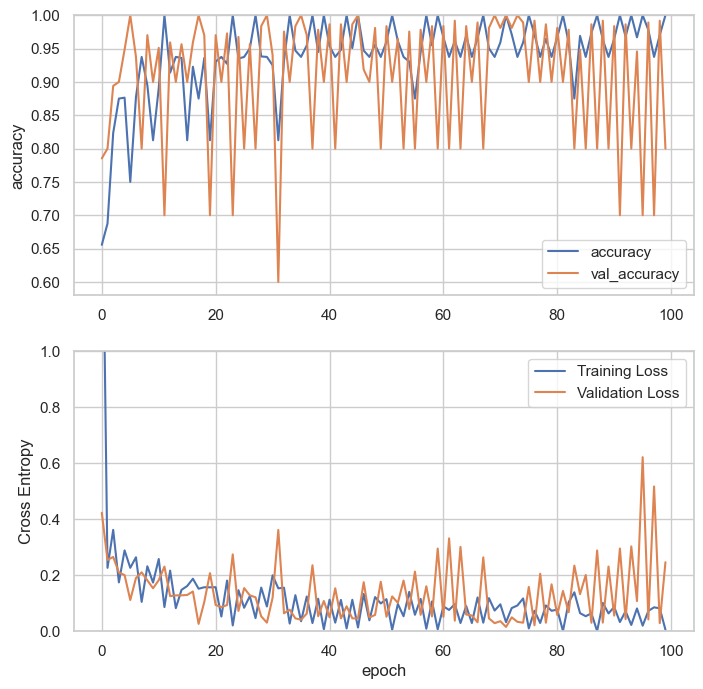

In [42]:
# plot history loss and accuracy over epochs
plot_history(fine_tuned_model_history, training_metric="accuracy", validation_metric="val_accuracy")

# Model Evaluation

In [6]:
# load the trained models
baseline_model = load_model("callbacks/baseline_model_checkpoint.keras")
fine_tuned_model = load_model("callbacks/fine_tuned_model_checkpoint.keras")

In [5]:
# get models validation data predictions
baseline_model_pred_prob = baseline_model.predict(validation_generator)
baseline_model_predictions = baseline_model_pred_prob > 0.5
fine_tuned_model_pred_prob = fine_tuned_model.predict(validation_generator)
fine_tuned_model_predictions = fine_tuned_model_pred_prob > 0.5

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 754ms/step


In [6]:
# get class indices
validation_generator.class_indices

{'def_front': 0, 'ok_front': 1}

In [7]:
# get the models reports
baseline_model_report = classification_report(validation_generator.classes, baseline_model_predictions)
fine_tuned_model_report = classification_report(validation_generator.classes, fine_tuned_model_predictions)
# print reports
print(f"* Baseline Model\n{baseline_model_report}\n* Fine Tuned Model\n{fine_tuned_model_report}")

* Baseline Model
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       231
           1       0.88      0.93      0.90       147

    accuracy                           0.92       378
   macro avg       0.92      0.92      0.92       378
weighted avg       0.93      0.92      0.92       378

* Fine Tuned Model
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       231
           1       0.95      1.00      0.98       147

    accuracy                           0.98       378
   macro avg       0.98      0.98      0.98       378
weighted avg       0.98      0.98      0.98       378



We see that the fine tuned model is better that tha baseline one depending on all the metrics

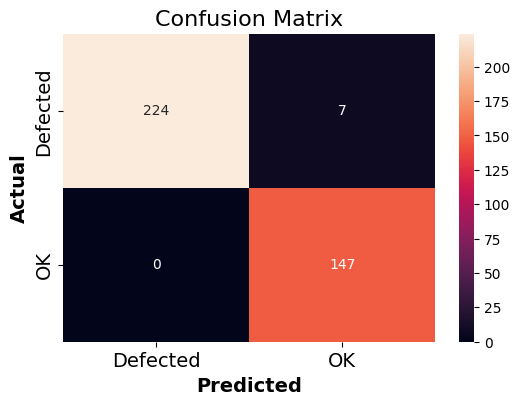

In [8]:
# plot the fine tuned model confusion matrix 
plt.figure(figsize=(6,4))
plt.title("Confusion Matrix", size=16)
sns.heatmap(
    confusion_matrix(validation_generator.classes, fine_tuned_model_predictions),
    annot=True,
    fmt='d',
    xticklabels=['Defected', 'OK'],
    yticklabels=['Defected', 'OK'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

The model is perfect for good piece detection but it is slightly less performant regarding the defected ones.

In [9]:
# get series for actual and predicted label
predicted_series = pd.Series(fine_tuned_model_predictions.reshape(-1))
actual_series = pd.Series(validation_generator.classes)
# compare labels
test_series = predicted_series == actual_series
# get the misclassidied images indexes
misclassidied_indices = test_series[test_series==False].index

In [34]:
# load validation data
validation_dataset = image_dataset_from_directory("data/test_data", 
                                                  batch_size=validation_generator.samples,
                                                  image_size=(224, 224),
                                                  shuffle=False)

Found 378 files belonging to 2 classes.


C:\Users\acer\AppData\Local\Temp\ipykernel_13268\2615262055.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  pred_label =  class_names[fine_tuned_model_predictions[i][0]]


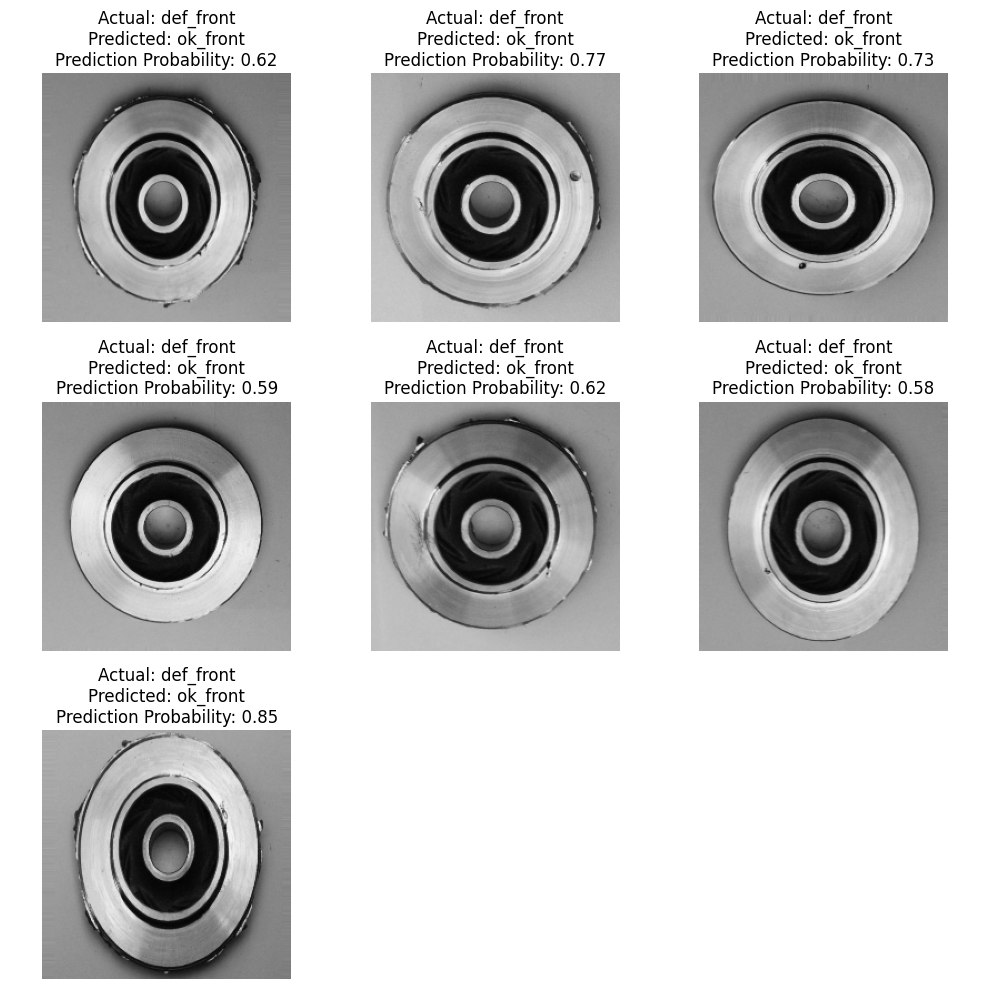

In [11]:
# plot misclassified pieces
j = 0
class_names = validation_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(validation_generator.samples):
        if i in misclassidied_indices:
            pred_prob = fine_tuned_model_pred_prob[i][0]
            actual_label =  class_names[labels[i]]
            pred_label =  class_names[fine_tuned_model_predictions[i][0]]
            axe = plt.subplot(3, 3, j+1)
            axe.imshow(images[j].numpy().astype("uint8"))
            axe.set_title(f"Actual: {actual_label}\nPredicted: {pred_label}\nPrediction Probability: {pred_prob:.2f}")
            j += 1
        plt.axis("off")
plt.tight_layout()